### Creació base de dades a partir de les taules de MIMIC-III

<font size="2">
Consideracions:<br>
- No totes les variables mantindran el nom de les taules d'on provenen, algunes variables seran assignades amb noms més explicatius.<br>
- D'algunes variables explicatives s'han deixat propostes de codificacions, però que no han sigut aplicades, ja que es pot fer un cop es tingui tot el data set final.
</font>

In [394]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#### Carreguem les taules

In [395]:
DATA_PATH = "../../data/input/"
DATA_PATH_OUT = "../../data/output/"

In [396]:
drgcodes = pd.read_csv(DATA_PATH+"DRGCODES.csv")
microbio = pd.read_csv(DATA_PATH+"MICROBIOLOGYEVENTS.csv")
patients = pd.read_csv(DATA_PATH+"PATIENTS.csv")
admissions = pd.read_csv(DATA_PATH+"ADMISSIONS.csv")
icustays = pd.read_csv(DATA_PATH+"ICUSTAYS.csv")
callout = pd.read_csv(DATA_PATH+"CALLOUT.csv")
transfers = pd.read_csv(DATA_PATH+"TRANSFERS.csv")
inputevents = pd.read_csv(DATA_PATH+"INPUTEVENTS_MV.csv")
cptevents = pd.read_csv(DATA_PATH+"CPTEVENTS.csv", low_memory=False)

#### Taula ICUSTAYS

Aquesta taula defineix una fila per cada estada a la UCI de cada pacient, on les estades són identificades de manera única pel *icustay_id*.

Aquesta taula està relacionada amb **Patients** amb *subject_id* i amb **Admissions** amb *hadm_id*.

##### Consideracions importants

- L'*icustay_id* no ha sigut generat a partir de cap identificador de les dades crues. Ja que a la base de dades de l'hospital i de la UCI la informació no està intrínsecament vinculada i, per tant, no existeix un identificador únic per estada a la UCI.
    
- La taula **Icustays** deriva de la taula **Transfers**. En particular, agrupa la informació de la taula **Transfers** segons l'identificador *icustays_id*, i exclou aquelles files on no existeix un *icustay_id*.

- La **clau primària** és l'identificador *icustays_id*.
<br>La clau primària en base de dades és una variable que identifica de manera única la informació, en el nostre cas, de cada pacient. Si aquesta variable fos eliminada podriem tenir dues files amb la mateixa informació pel mateix pacient, cosa que no seria cert perquè serien diferents estades a la UCI
- Les **claus foràneas** són: *subject_id* i *hadm_id*. 
<br>Les claus foràneas en base de dades són variables que relacionen una taula amb altres, i a més a més, aquestes claus foràneas són claus primàries d'aquestes altres taules.

<br>**Aquesta taula serà utilitzada per agafar els pacients que han estat com a mínim un cop a la UCI entre 2008 i 2012.**

#### Descartem aquells pacients que van ser recollits amb el sistema informàtic CareVue, ens quedem només amb els pacients de Metavision. 

In [397]:
icustays8_12 = icustays[icustays["DBSOURCE"] == "metavision"]

In [398]:
icustays_unique = icustays8_12.drop_duplicates(subset="SUBJECT_ID")

In [399]:
#número de pacients enregistrat en el sistema Metavision (pacients entre 2008-2012)
num_pacients = icustays_unique["SUBJECT_ID"].shape
print(f"Tenim {num_pacients[0]} pacients enregistrat en el sistema metavision")

Tenim 17710 pacients enregistrat en el sistema metavision


#### De les taules Admissions i Patients agafem els pacients entre 2008-2012 

In [400]:
admissions_icu = admissions.loc[admissions["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
admissions_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
12,33,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1
13,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1
15,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1


In [401]:
patients_icu = patients.loc[patients["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
patients_icu.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
15,249,266,F,2090-12-17 00:00:00,NaN,NaN,NaN,0
22,628,665,M,2052-05-20 00:00:00,2120-02-04 00:00:00,2120-02-04 00:00:00,NaN,1
28,634,671,M,2148-03-27 00:00:00,NaN,NaN,NaN,0
44,650,689,F,2128-12-27 00:00:00,NaN,NaN,NaN,0


#### Transformacions de la taula PATIENTS

Aquesta taula indica els pacients que estan associats com a mínim amb una admissió a la UCI. Aquesta està relacionada amb les taules **Admissions** i **Icustays** a través del *Subject_id*.

##### Consideracions importants
 - **DOB** han sigut desplaçades per pacients d'edat > 89 anys, és a dir, a aquests pacients se li han sumat 210 anys a la seva DOB. La mediana d'edat per pacients dels quals l'edat ha sigut desplaçada és 91,4.

 - Subject_id és la *clau primaria*, és a dir, que si s'elimina aquesta columna podria haver-hi files amb valors duplicats.
 
 
Ens quedem amb les variables d'interès, en aquest cas:
 - Subject_id: Identificador únic per cada pacient.
 - Gender
 - Expire_flag (0 si el pacient viu, 1 si mort)
 - DOB (Date Of Birth)
 - DOD (Date of Death)
 - DOD_HOSP: Si el pacient a mort a l'hospital el valor és el mateix que el de la columna DOD, si no és NaN.

In [402]:
patients_df = pd.DataFrame()
patients_df["subject_id"] = patients_icu.loc[:,"SUBJECT_ID"]

In [403]:
patients_df["gender"] = patients_icu.loc[:,"GENDER"]

In [404]:
patients_df["is_dead"] = patients_icu.loc[:,"EXPIRE_FLAG"]

In [405]:
patients_df["DOB"] = patients_icu.loc[:,"DOB"]

In [406]:
patients_df["DOD"] = patients_icu.loc[:,"DOD"]

In [407]:
patients_df["is_dead_hosp"] = patients_icu.loc[:,"DOD_HOSP"] 

In [408]:
patients_df["is_dead_hosp"] = patients_icu.loc[:,"DOD_HOSP"].apply(lambda x: 1 if pd.notna(x) else 0)

In [409]:
patients_df.head()

,subject_id,gender,is_dead,DOB,DOD,is_dead_hosp
0,249,F,0,2075-03-13 00:00:00,NaN,0
15,266,F,0,2090-12-17 00:00:00,NaN,0
22,665,M,1,2052-05-20 00:00:00,2120-02-04 00:00:00,1
28,671,M,0,2148-03-27 00:00:00,NaN,0
44,689,F,0,2128-12-27 00:00:00,NaN,0


#### Transformacions necessàries per la taula ADMISSIONS

Aquesta taula conté informació sobre les admissions dels pacients a l'hospital. Cada pacient és assignat un *hadm_id* per cada estada a l'hospital. Està relacionada amb la taula **Patients** a través del *subject_id*.

##### Consideracions importants

 - Les dades de la taula han sigut recollides de les bases de dades d'admissions, discharge i transfers del hospital. Normalment, es fa referència a aquest tipus de dades com dades 'ADT'.

 - Es contempla informació de donants d'organs que han mort durant l'estada a l'hospital. Aquest tipus de pacients, després de la seva mort, son registrats com noves admissions a l'hospital molt curtes, on la Length Of Stay pot tenir valors negatius. A més a més, el temps de l'admissió concorda amb el temps de la mort de l'última admissió del pacient.

 - La **clau primaria** d'aquesta taula és la columna *hadm_id*.
 
 - La **clau forana**, és a dir, els valors d'aquesta taula utilitzats per relacionar-la amb altres taules és la columna *subject_id*.

Ens quedem amb les següents variables: 

 - Subject_ID
 - ADMITTIME: Data i temps en el que el pacient va ser admès a l'hospital.
 - ADMISSION_TYPE: Tipus d'admissió, pot ser:
    - Urgent
    - Elective
    - Newborn 
    - Emergency.
 - Diagnosis.
 - DISCHARGE_LOCATION: 
    - Home
    - Home Health Care
    - Dead/Expired
    - SNF(Skilled Nursing Facility).
    
 - ADMIT_LOCATION:
    - Phys referal/normal deli: El pacient és derivat a un altre tipus de metge però sense ser una urgència.
    - Emergency room admit.
    - Clinic referral/premature: El pacient és transferit a un altre centre de manera urgent per canvis en l'estat d'aquest.
    - Transfer from other hosp: El pacient ha sigut transferit des d'un altre centre mèdic.
    - TRSF within this facility

 - ETHNICITY:
    - American Indian/Alaska Native; American Indian/Alaska Native Federally Recognized Tribe.
    - Asian, Asian-Filipino, Asian-Cambodian, Asian-Chinese, Asian-Japanese, Asian-Korean, Asian-Thai, Asian-Vietnamese, Asian-Other.
    - Black/African, Black/African American, Black/Cape verdeam, Black/haitian.
    - Caribbean Island
    - Hispanic or Latino, Hispanic/Latino-Central American(other), Hispanic/Latino-Colombian, Hispanic/Latino-Cuban, Hispanic/Latino-Dominican, 
      Hispanic/Latino-Guatemalan, Hispanic/Latino-Honduran, Hispanic/Latino-Mexican, Hispanic/Latino-Puerto Rican, Hispanic/Latino-Salvadoran.
    - Middle eastern.
    - Multi race ethnicity.
    - Native Hawaiian or other pacific islander.
    - Patient declined to answer.
    - Portuguese.
    - South American.
    - Unable to obtain.
    - Unknown/not specified
    - White, White-Brazilian, White-Eastern European, White-Other European, White-Russian.

In [410]:
admissions_df = pd.DataFrame()

In [411]:
admissions_df["subject_id"] = admissions_icu.loc[:,"SUBJECT_ID"]

In [412]:
admissions_df["hadm_id"] = admissions_icu.loc[:,"HADM_ID"]

In [413]:
admissions_df["admit_datetime"] = admissions_icu.loc[:,"ADMITTIME"]

Proposta de codificació del tipus d'admissió al hospital: 
- 1 si és una intervenció mèdica o quirúrgica planificada no d'urgències.
- 2 si urgències o emergència.

In [414]:
#adm_type_arr = np.array(admissions_icu["ADMISSION_TYPE"])
#adm_type_arr[adm_type_arr == "ELECTIVE"] = 1
#adm_type_arr[adm_type_arr != 1] = 2

In [415]:
admissions_df["admission_type"] = admissions_icu.loc[:,"ADMISSION_TYPE"]

Codificació del lloc d'admissió al hospital
- 1 si PHYS REFERRAL/NORMAL DELI, és a dir, si el pacient és derivat a un altre tipus de metge però sense ser una urgència.
- 2 si TRANSFER FROM HOSP/EXTRAM o TRANSFER FROM OTHER HEALT, és a dir, el pacient ha sigut transferit des d'un altre centre mèdic.
- 3 si CLINIC REFERRAL/PREMATURE, és a dir, si el pacient és transferit a un altre centre de manera urgent per canvis en l'estat d'aquest.
- 4 si EMERGENCY ROOM ADMIT
- 5 si TRANSFER FROM SKILLED NUR, és a dir, el pacient és transferit des d'una altre unitat de cuidats especialitzats (normalment, per pacients en rehabilitació o amb malalties de llarga durada)
- 6 si TRSF WITHIN THIS FACILITY

In [416]:
"""
admloc_type = np.array(admissions_icu["ADMISSION_LOCATION"])

for tp in range(len(admit_location_types)):
    if admit_location_types[tp] == "TRANSFER FROM OTHER HEALT":
        admloc_type[admloc_type == admit_location_types[tp]] = 2
    if tp == 6:
        admloc_type[admloc_type == admit_location_types[tp]] = tp
    else:
        admloc_type[admloc_type == admit_location_types[tp]] = tp+1
"""

'\nadmloc_type = np.array(admissions_icu["ADMISSION_LOCATION"])\n\nfor tp in range(len(admit_location_types)):\n    if admit_location_types[tp] == "TRANSFER FROM OTHER HEALT":\n        admloc_type[admloc_type == admit_location_types[tp]] = 2\n    if tp == 6:\n        admloc_type[admloc_type == admit_location_types[tp]] = tp\n    else:\n        admloc_type[admloc_type == admit_location_types[tp]] = tp+1\n'

In [417]:
# Com que l'etiqueta "Transfer from hosp/extram" té el mateix significat que "Transfer from other health",
# la canviem a "Transfer from other hosp" per tots els pacients que tinguin el valor d'alguna de les dues anteriors.

admloc_type = np.array(admissions_icu.loc[:,"ADMISSION_LOCATION"])
admloc_type[admloc_type == "TRANSFER FROM HOSP/EXTRAM"] = "TRANSFER FROM OTHER HOSP"
admloc_type[admloc_type == "TRANSFER FROM OTHER HEALT"] = "TRANSFER FROM OTHER HOSP"
admissions_df["admit_location"] = admloc_type

In [418]:
admissions_df["diagnosis"] = admissions_icu.loc[:,"DIAGNOSIS"]

In [419]:
admissions_df["ethnicity"] = admissions_icu.loc[:,"ETHNICITY"]

In [420]:
admissions_df["discharge_location"] = admissions_icu.loc[:,"DISCHARGE_LOCATION"]

In [421]:
# Veiem els valors que pot prendre aquesta variable
np.unique(admissions_df["discharge_location"])

array(['DEAD/EXPIRED', 'DISC-TRAN CANCER/CHLDRN H',
       'DISC-TRAN TO FEDERAL HC', 'DISCH-TRAN TO PSYCH HOSP', 'HOME',
       'HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR', 'HOSPICE-HOME',
       'HOSPICE-MEDICAL FACILITY', 'ICF', 'LEFT AGAINST MEDICAL ADVI',
       'LONG TERM CARE HOSPITAL', 'OTHER FACILITY',
       'REHAB/DISTINCT PART HOSP', 'SHORT TERM HOSPITAL', 'SNF'],
      dtype=object)

In [422]:
# Creem un diccionari amb els valors amb els que volem agrupar els resultats anteriors.
values_dictionary = {1: "DEAD", 2: "HOME", 3: "HOME WHC", 4: "HOSPICI", 5: "ALTRES"}

In [423]:
# Agrupem els valors de "discharge_location" en els diferents valors del diccionari creat.
discharge_locs = np.array(admissions_icu.loc[:,"DISCHARGE_LOCATION"])

hospital = ['DISC-TRAN CANCER/CHLDRN H','DISC-TRAN TO FEDERAL HC', 'DISCH-TRAN TO PSYCH HOSP', 'SHORT TERM HOSPITAL', 'LONG TERM CARE HOSPITAL']
home_w_health_care = ['HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR']
hospici = ['HOSPICE-HOME','HOSPICE-MEDICAL FACILITY', 'ICF', 'SNF']
other = ['OTHER FACILITY', 'LEFT AGAINST MEDICAL ADVI']

discharge_locs[discharge_locs == "DEAD/EXPIRED"] = values_dictionary[1]
discharge_locs[np.in1d(discharge_locs, hospital)] = values_dictionary[5]
discharge_locs[np.in1d(discharge_locs, home_w_health_care)] = values_dictionary[3]
discharge_locs[np.in1d(discharge_locs, hospici)] = values_dictionary[4]
discharge_locs[discharge_locs == 'REHAB/DISTINCT PART HOSP'] = values_dictionary[5]
discharge_locs[np.in1d(discharge_locs, other)] = values_dictionary[5]

# Els valors 'HOME' i 'LONG TERM HOSPITAL' com es quedaven igual no se'ls ha fet cap operació.

In [424]:
# Canviem els valors de la columna "discharge_location" a els nous valors assignats.
admissions_df["discharge_location"] = discharge_locs

In [425]:
admissions_df.head()

,subject_id,hadm_id,admit_datetime,admission_type,admit_location,diagnosis,ethnicity,discharge_location
1,23,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC
2,23,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC
12,34,115799,2186-07-18 16:46:00,EMERGENCY,TRANSFER FROM OTHER HOSP,CHEST PAIN\CATH,WHITE,HOME
13,34,144319,2191-02-23 05:23:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,BRADYCARDIA,WHITE,HOME WHC
15,36,182104,2131-04-30 07:15:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC


Unim la taula PATIENTS i ADMISSIONS

In [426]:
admis_with_patients_df = patients_df.merge(admissions_df, on="subject_id", how="right")
admis_with_patients_df.head()

,subject_id,gender,is_dead,DOB,DOD,is_dead_hosp,hadm_id,admit_datetime,admission_type,admit_location,diagnosis,ethnicity,discharge_location
0,23,M,0,2082-07-17 00:00:00,NaN,0,152223,2153-09-03 07:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC
1,23,M,0,2082-07-17 00:00:00,NaN,0,124321,2157-10-18 19:34:00,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC
2,34,M,1,1886-07-18 00:00:00,2192-01-30 00:00:00,0,115799,2186-07-18 16:46:00,EMERGENCY,TRANSFER FROM OTHER HOSP,CHEST PAIN\CATH,WHITE,HOME
3,34,M,1,1886-07-18 00:00:00,2192-01-30 00:00:00,0,144319,2191-02-23 05:23:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,BRADYCARDIA,WHITE,HOME WHC
4,36,M,0,2061-08-17 00:00:00,NaN,0,182104,2131-04-30 07:15:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC


Fem el càlcul de l'edat dels pacients en cada estada amb l'admit_datetime i la DOB i esborrem aquestes dues columnes

In [427]:
# Canviem el datetime object de "admit_datetime" i "DOB" per poder calcular la diferència.
admis_with_patients_df["age"] = admis_with_patients_df.apply(lambda x: (datetime.strptime(x["admit_datetime"], "%Y-%m-%d %H:%M:%S") - datetime.strptime(x["DOB"], "%Y-%m-%d %H:%M:%S")).days//365, axis=1)

In [428]:
# Els pacients que tenen edats => a 300 anys els hi restem 210 anys per trobar l'edat correcta dels pacients amb edats >= 90
admis_with_patients_df["age"] = admis_with_patients_df["age"].apply(lambda x: x-210 if x>=300 else x)

In [429]:
# Eliminem les columnes de "DOB" i admit_datetime perquè ja no les necessitem
admis_with_patients_df.drop(["DOB", "admit_datetime"], axis=1, inplace=True)

In [430]:
admis_with_patients_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75
2,34,M,1,2192-01-30 00:00:00,0,115799,EMERGENCY,TRANSFER FROM OTHER HOSP,CHEST PAIN\CATH,WHITE,HOME,90
3,34,M,1,2192-01-30 00:00:00,0,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,BRADYCARDIA,WHITE,HOME WHC,94
4,36,M,0,NaN,0,182104,EMERGENCY,CLINIC REFERRAL/PREMATURE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,69


#### Transformacions necessàries per la taula CALLOUT

Aquesta taula conté informació sobre els pacients que estaven preparats per ser donats d'alta a la UCI, i si realment es van donar d'alta. Quan a un pacient li arriba l'hora d'abandonar la UCI, se sol dir que el pacient és "called out". Aquest procés contempla les següents passes: 

   1. Registrar que el pacient està preparat per deixar la UCI i les precaucions especials que cal prendre si es requereixen. <br>
   2. L'aprovació d'un superior demanant un llit fora de la UCI.<br>
   3. Un període de temps considerat per fer la transferència del pacient fora de la UCI.<br>
   4. La resolució: Si finalment el pacient abandona la UCI o no.

La taula **Callout** està relacionada amb la taula **Patients** a través del *subject_id* i la taula **Admissions** a través del *hadm_id*.

##### Consideracions importants

 - No hi ha dades en aquesta taula per tots els pacients adults.

 - La informació d'aquesta taula mai es troba per nounats.

 - La **clau primària** és *row_id*.

 - Les **claus foranes** són: *subject_id* i *hadm_id*.<br>

<br>Ens quedem amb les següents variables: 

 - HADM_ID: Identificador de l'admissió a l'hospital del pacient.
 - CURR_CAREUNIT: Tipus de UCI actual del pacient.
 
     - CCU: Coronary care unit
     - CSRU: Cardiac surgery recovery unit
     - MICU: Medical intensive care unit
     - NICU: Neonatal intensive care unit
     - NWARD: Neonatal ward
     - SICU: Surgical intensive care unit
     - TSICU: Trauma/surgical intensive care unit

 - CALLOUT_SERVICE: Servei mèdic al qual el pacient és donat d'alta.
 
      - CCU: Coronary Care Unit
      - CMED: Cardiac Medical
      - CSURG: Cardiac Surgery
      - ENT: Department that looks after patiens who have diseases or symptoms affecting Ear, Nose, and Throat.
      - GU: Genitourinary
      - GYN: Gynecology
      - MED: Medical
      - NB: Newborn
      - NBB: Newborn Nursery
      - NMED: Neonatal Medical
      - NSURG: Neonatal Surgical
      - OBS: Obstetrics
      - OMED: Obstetric Medical
      - ORTHO: Orthopedic
      - PSURG: Plastic Surgery
      - PSYCH: Psychiatry
      - SURG: Surgical
      - TRAUM: Trauma
      - TSURG: Trauma Surgery
      - VSURG: Vascular Surgery

 - CALLOUT_OUTCOME: 
    - Cancelled: Si el procés ha sigut cancel·lat, el pacient roman a la UCI.
    - Discharged: El pacient ha sigut donat d'alta de la UCI

 - OUTCOMETIME: Temps i data en les que es va realitzar el callout.

In [431]:
# Agafem els pacients de la taula callout que han sigut enregistrats entre 2008-2012 (sistema Metavision)
callout_icu = callout.loc[callout["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
callout_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,402,854,175684,52.0,NaN,29.0,MICU,1,MED,0,...,Inactive,Discharged,29.0,Acknowledged,2146-10-05 13:16:55,2146-10-05 13:16:55,2146-10-05 13:24:00,2146-10-05 18:55:22,2146-10-05 15:27:44,NaN
26,179,357,174486,23.0,MICU,23.0,MICU,1,MED,0,...,Inactive,Cancelled,NaN,Acknowledged,2197-12-24 12:13:26,2197-12-25 07:54:05,2197-12-25 07:04:25,2197-12-25 07:54:05,NaN,NaN
27,180,357,174486,23.0,NaN,54.0,MICU,1,MED,0,...,Inactive,Discharged,54.0,Revised,2197-12-26 11:21:41,2197-12-26 14:56:20,NaN,2197-12-26 15:40:05,NaN,NaN
28,181,357,145674,50.0,NaN,3.0,MICU,1,NMED,1,...,Inactive,Discharged,3.0,Acknowledged,2198-08-02 20:23:27,2198-08-02 20:23:27,2198-08-03 06:58:58,2198-08-04 02:10:04,NaN,NaN
29,182,357,101651,7.0,NaN,55.0,CCU,1,CCU,0,...,Inactive,Discharged,55.0,Acknowledged,2199-10-20 17:36:30,2199-10-20 17:36:30,2199-10-20 17:58:24,2199-10-21 10:40:05,NaN,NaN


In [432]:
callout_df = pd.DataFrame()

In [433]:
callout_df["subject_id"] = callout_icu.loc[:,"SUBJECT_ID"]

In [434]:
callout_df["hadm_id"] = callout_icu.loc[:,"HADM_ID"]

In [435]:
callout_df["current_careunit"] = callout_icu.loc[:,"CURR_CAREUNIT"]

In [436]:
callout_df["discharge_careunit"] = callout_icu.loc[:,"CALLOUT_SERVICE"]

In [437]:
callout_df["is_discharged"] = callout_icu.loc[:, "CALLOUT_OUTCOME"].apply(lambda x: 0 if x.lower()=="cancelled" else 1)

In [438]:
callout_df["icu_out_time"] = callout_icu.loc[:,"OUTCOMETIME"]

In [439]:
num_discharged = np.array(callout_df.loc[:,"is_discharged"])
print(f"Número d'estades de pacients a l'hospital on la variable is_discharge = 1: {np.sum(num_discharged)}")
print(f"Número d'estades de pacients a l'hospital totals de la taula callout: {callout_df.shape[0]}")

Número d'estades de pacients a l'hospital on la variable is_discharge = 1: 20559
Número d'estades de pacients a l'hospital totals de la taula callout: 23779


In [440]:
# Eliminem aquelles files on el pacient no ha sigut transferit, és a dir is_discharged = 0
callout_df = callout_df[callout_df["is_discharged"] == 1]

In [441]:
# Esborrem la columna is_discharged perquè no proporciona informació rellevant, ja que l'estat de is_discharged de tots els pacients és el mateix.
callout_df = callout_df.drop(columns=["is_discharged"])

In [442]:
callout_df.head()

,subject_id,hadm_id,current_careunit,discharge_careunit,icu_out_time
0,854,175684,MICU,MED,2146-10-05 18:55:22
27,357,174486,MICU,MED,2197-12-26 15:40:05
28,357,145674,MICU,NMED,2198-08-04 02:10:04
29,357,101651,CCU,CCU,2199-10-21 10:40:05
32,357,117876,SICU,NMED,2200-01-07 21:40:04


In [443]:
# Ordena per files segons els valors de les columnes de "hadm_id" i "icu_out_time" de manera ascendent.
callout_df = callout_df.sort_values(["hadm_id", "icu_out_time"], axis=0)

In [444]:
# Comptem quants cops apareix el mateix "hadm_id" per saber quants cops ha sigut ingressat a la UCI un pacient a la mateixa estada al hospital
callout_df["callout_id"] = callout_df.groupby(["hadm_id"]).cumcount()+1

In [445]:
# Calculem un id únic per estades a la UCI
callout_df["callout_id"] = callout_df.apply(lambda x: str(x["hadm_id"])+"_"+str(x["callout_id"]), axis=1)

In [446]:
callout_df.head()

,subject_id,hadm_id,current_careunit,discharge_careunit,icu_out_time,callout_id
24784,58526,100001,MICU,MED,2117-09-15 18:14:40,100001_1
19431,54610,100003,MICU,MED,2150-04-19 14:25:08,100003_1
22156,55853,100010,SICU,GU,2109-12-12 12:28:10,100010_1
31925,87977,100011,TSICU,TRAUM,2177-09-09 17:11:45,100011_1
24997,60039,100012,CSRU,CSURG,2177-03-18 00:57:27,100012_1


In [447]:
# Comprovem per algun pacient que s'hagit fet bé la creació d'aquest identificador
paciente_249 = callout_df[callout_df["subject_id"] == 249]
paciente_249

,subject_id,hadm_id,current_careunit,discharge_careunit,icu_out_time,callout_id
67,249,149546,MICU,MED,2155-02-05 18:55:23,149546_1
68,249,149546,TSICU,NMED,2155-02-11 16:25:30,149546_2
70,249,158975,MICU,CCU,2156-05-03 18:56:13,158975_1
71,249,158975,MICU,SURG,2156-05-11 19:43:38,158975_2


#### Transformacions necessàries per la taula TRANSFERS

Aquesta taula indica els serveis de l'hospital pels que ha passat el pacient, i la informació de cada transferència d'un servei mèdic a un altre.

Està relacionada amb les taules: **Patients**, a través del *subject_id*; **Admissions**, a través del *hadm_id*, i amb la taula **Icustays**, a través de l'identificador *icustays_id*.

##### Consideracions importants

 - La taula **Icustays** deriva d'aquesta.

 - Les ICUs estan definides segons diferents *wardID*'s les quals estan associades amb una ICU.

 - Les ICUs han anat canviant durant els anys de localitzacions a l'hospital, per tant, un *wardID* pot fer referència a una ICU pel pacient A, però no fa referència a la mateixa ICU per un altre pacient B. Com a resultat, aquesta variable i les que estiguin relacionades amb aquesta no seran considerades.

 - La **clau primària** és l'identificador *row_id*.

 - Les **claus foranes** són: *subject_id*, *hadm_id* i *icustays_id*.


<br>Ens quedem amb les següents variables: 

 - HADM_ID: ID de l'admissió a l'hospital del pacient.
 - SUBJECT_ID: ID únic pel pacient.
 - EVENTYPE:
     - Admit: Si el pacient és admès.
     - Transfer: El pacient és transferit dins del mateix hospital.
     - Discharge: El pacient se li dona l'alta de l'hospital.
 - PREV_CAREUNIT: La UCI en la què es trobava prèviament el pacient.
 - CURR_CAREUNIT: La UCI on actualment es troba el pacient.
 - INTIME: Temps i data en la què el pacient ha entrat a la curr_careunit.
 - OUTTIME: Temps i data en el que el pacient ha sortit de la curr_careunit
 - LOS: Lenght of Stay, mesurat en hores.

 - Tipus de CAREUNITS:
     - CCU: Coronary care unit
     - CSRU: Cardiac surgery recovery unit
     - MICU: Medical intensive care unit
     - NICU: Neonatal intensive care unit
     - NWARD: Neonatal ward
     - SICU: Surgical intensive care unit
     - TSICU: Trauma/surgical intensive care unit

In [448]:
#Agafem els pacients entre 2008 i 2012
transfers_icu = transfers.loc[transfers["DBSOURCE"]== "metavision"]
transfers_icu = transfers_icu.loc[transfers_icu["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
transfers_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
3,660,111,155897,249202.0,metavision,admit,NaN,MICU,NaN,52.0,2144-07-01 04:13:59,2144-07-01 05:19:39,1.09
4,661,111,155897,NaN,metavision,transfer,MICU,NaN,52.0,32.0,2144-07-01 05:19:39,2144-07-01 06:28:29,1.15
5,662,111,155897,249202.0,metavision,transfer,NaN,MICU,32.0,52.0,2144-07-01 06:28:29,2144-07-01 08:07:16,1.65
6,663,111,155897,NaN,metavision,transfer,MICU,NaN,52.0,32.0,2144-07-01 08:07:16,2144-07-01 08:13:51,0.11
7,664,111,155897,249202.0,metavision,transfer,NaN,MICU,32.0,23.0,2144-07-01 08:13:51,2144-07-01 17:56:31,9.71


In [449]:
transfers_df = pd.DataFrame()

In [450]:
transfers_df["subject_id"] = transfers_icu.loc[:,"SUBJECT_ID"]

In [451]:
transfers_df["hadm_id"] = transfers_icu.loc[:,"HADM_ID"]

In [452]:
transfers_df["event_type"] = transfers_icu.loc[:,"EVENTTYPE"]

In [453]:
transfers_df["prev_careunit"] = transfers_icu.loc[:,"PREV_CAREUNIT"]

In [454]:
transfers_df["current_careunit"] = transfers_icu.loc[:,"CURR_CAREUNIT"]

In [455]:
transfers_df["in_time"] = transfers_icu.loc[:,"INTIME"]

In [456]:
transfers_df["out_time"] = transfers_icu.loc[:,"OUTTIME"]

In [457]:
transfers_df["LOS"] = transfers_icu.loc[:,"LOS"]

In [458]:
# Ordena per files segons els valors de les columnes de "hadm_id" i "out_time" de manera ascendent.
transfers_df = transfers_df.sort_values(["hadm_id", "out_time"], axis=0)

In [459]:
# Volem crear l'identificador callout_id per poder fer la unió entre la taula transfers i callout.
# Primer creem una variable booleana ("should_have_id") que indicarà com "True" els callouts d'una UCI a un altre servei mèdic que no sigui el mateix tipus de UCI
# o directament, cap UCI. En cas contrari, serà "False".
transfers_df["should_have_id"] = transfers_df.apply(lambda x: False if pd.isna(x["prev_careunit"]) or x["prev_careunit"] == x["current_careunit"] else True, axis=1)

In [460]:
# Agrupem la taula per "hadm_id" i comptem els callouts d'interés, aquells on la variable should_have_id = True.
transfers_df["callout_id"] = transfers_df.groupby('hadm_id')['should_have_id'].transform(lambda x: x.cumsum())

In [461]:
# Creem l'identificador per les transferències d'interés, i a la resta els hi assignem NaN
transfers_df["callout_id"] = transfers_df.apply(lambda x: np.nan if not x["should_have_id"] else str(x["hadm_id"])+"_"+str(int(x["callout_id"])), axis=1)

In [462]:
transfers_df.head()

,subject_id,hadm_id,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,should_have_id,callout_id
193492,58526,100001,admit,NaN,MICU,2117-09-11 11:47:35,2117-09-11 12:51:56,1.07,False,NaN
193493,58526,100001,transfer,MICU,MICU,2117-09-11 12:51:56,2117-09-15 17:57:14,101.09,False,NaN
193494,58526,100001,transfer,MICU,NaN,2117-09-15 17:57:14,2117-09-17 16:46:20,46.82,True,100001_1
193495,58526,100001,discharge,NaN,NaN,2117-09-17 16:46:20,NaN,NaN,False,NaN
203051,54610,100003,admit,NaN,MICU,2150-04-17 15:35:42,2150-04-17 15:51:17,0.26,False,NaN


In [463]:
#Observem la informació d'un pacient en concret per veure que hem aconseguit el que voliem
transfers_df[transfers_df["subject_id"] == 249]

,subject_id,hadm_id,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,should_have_id,callout_id
2043,249,149546,admit,NaN,MICU,2155-02-03 20:17:29,2155-02-05 18:34:02,46.28,False,NaN
2044,249,149546,transfer,MICU,NaN,2155-02-05 18:34:02,2155-02-07 16:57:52,46.40,True,149546_1
2045,249,149546,transfer,NaN,NaN,2155-02-07 16:57:52,2155-02-07 18:51:16,1.89,False,NaN
2046,249,149546,transfer,NaN,TSICU,2155-02-07 18:51:16,2155-02-11 16:00:39,93.16,False,NaN
2047,249,149546,transfer,TSICU,NaN,2155-02-11 16:00:39,2155-02-11 18:45:05,2.74,True,149546_2
2048,249,149546,transfer,NaN,NaN,2155-02-11 18:45:05,2155-02-14 11:16:26,64.52,False,NaN
2049,249,149546,discharge,NaN,NaN,2155-02-14 11:16:26,NaN,NaN,False,NaN
2050,249,158975,admit,NaN,NaN,2156-04-27 15:33:52,2156-04-30 13:36:21,70.04,False,NaN
2051,249,158975,transfer,NaN,NaN,2156-04-30 13:36:21,2156-04-30 13:49:31,0.22,False,NaN
2052,249,158975,transfer,NaN,NaN,2156-04-30 13:49:31,2156-04-30 14:21:38,0.54,False,NaN


In [464]:
# Comprovem que aquest callout_id concorda entre les dues taules per aquest pacient
callout_df[callout_df["subject_id"] == 249]

,subject_id,hadm_id,current_careunit,discharge_careunit,icu_out_time,callout_id
67,249,149546,MICU,MED,2155-02-05 18:55:23,149546_1
68,249,149546,TSICU,NMED,2155-02-11 16:25:30,149546_2
70,249,158975,MICU,CCU,2156-05-03 18:56:13,158975_1
71,249,158975,MICU,SURG,2156-05-11 19:43:38,158975_2


### Unim la taula _transfers_ amb _callout_

In [465]:
transfers_callout_df = transfers_df.merge(callout_df, on=["subject_id", "hadm_id", "callout_id"], how="left", suffixes=("_transfers", "_callout"))

In [466]:
transfers_callout_df.head()

,subject_id,hadm_id,event_type,prev_careunit,current_careunit_transfers,in_time,out_time,LOS,should_have_id,callout_id,current_careunit_callout,discharge_careunit,icu_out_time
0,58526,100001,admit,NaN,MICU,2117-09-11 11:47:35,2117-09-11 12:51:56,1.07,False,NaN,NaN,NaN,NaN
1,58526,100001,transfer,MICU,MICU,2117-09-11 12:51:56,2117-09-15 17:57:14,101.09,False,NaN,NaN,NaN,NaN
2,58526,100001,transfer,MICU,NaN,2117-09-15 17:57:14,2117-09-17 16:46:20,46.82,True,100001_1,MICU,MED,2117-09-15 18:14:40
3,58526,100001,discharge,NaN,NaN,2117-09-17 16:46:20,NaN,NaN,False,NaN,NaN,NaN,NaN
4,54610,100003,admit,NaN,MICU,2150-04-17 15:35:42,2150-04-17 15:51:17,0.26,False,NaN,NaN,NaN,NaN


In [467]:
# Canviem l'objecte dels elements de les columnes "icu_out_time_*" a pandas datetime. 
transfers_callout_df[['in_time', 'icu_out_time']] = transfers_callout_df[['in_time', 'icu_out_time']].apply(pd.to_datetime)

Comprovem que els valors del temps quan s'efectuen els callouts i les transferències siguin molt petites

In [468]:
# Calculem la diferència entre els elements de les columnes "icu_out_time" i "in_time", sabent que normalment el "in_time" és una mica menor al de
#"icu_out_time".
diff_icu_outtime = pd.DataFrame()
diff_icu_outtime["difference"] = transfers_callout_df['icu_out_time'] - transfers_callout_df['in_time']

In [469]:
# Pels valors que son NaN els substituim per 0
diff_icu_outtime.fillna(pd.Timedelta(seconds=0))

,difference
0,0 days 00:00:00
1,0 days 00:00:00
2,0 days 00:17:26
3,0 days 00:00:00
4,0 days 00:00:00
...,...
99014,0 days 00:00:00
99015,0 days 00:00:00
99016,0 days 00:00:00
99017,0 days 00:00:00


Veiem que hi ha molts pocs valors on la diferència és més gran d'hora i mitja.


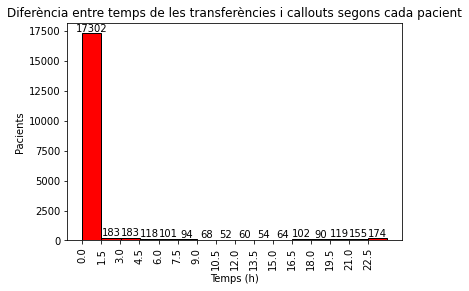

In [470]:
# Mostrem la frequencia de valors faltants segons els valors de la diferència en segons.
my_hist = diff_icu_outtime["difference"].dt.seconds
#my_hist.plot(kind='hist', color='blue', edgecolor='black', bins=50)
counts, edges, bars = plt.hist(my_hist, bins=16, ec="black", lw=1, color="red", align="mid")
plt.bar_label(bars)
plt.xlabel("Temps (h)")
plt.ylabel("Pacients")
plt.xticks(np.arange(0, 86400, step=5400), labels= np.arange(0.,24.,step=1.5), rotation=90)
plt.title("Diferència entre temps de les transferències i callouts segons cada pacient")
print("Veiem que hi ha molts pocs valors on la diferència és més gran d'hora i mitja.")

De moment aquests pacients no els eliminem, perquè sempre som a temps de fer-ho. De totes maneres, ens quedarem amb el "in_time" de les transferències perquè reflecteix els temps entre totes les transferències no només aquelles que s'han fet des d'una ICU.

In [471]:
transfers_callout_df["current_careunit_transfers"] = transfers_callout_df.apply(lambda x: x["discharge_careunit"] if pd.notna(x["callout_id"]) else x["current_careunit_transfers"], axis=1)

In [472]:
# Comprovació de què ha la informació de discharge_careunit s'ha passat correctament a la columna de current_careunit_transfers
transfers_callout_df[transfers_callout_df["subject_id"] == 249]

,subject_id,hadm_id,event_type,prev_careunit,current_careunit_transfers,in_time,out_time,LOS,should_have_id,callout_id,current_careunit_callout,discharge_careunit,icu_out_time
48625,249,149546,admit,NaN,MICU,2155-02-03 20:17:29,2155-02-05 18:34:02,46.28,False,NaN,NaN,NaN,NaT
48626,249,149546,transfer,MICU,MED,2155-02-05 18:34:02,2155-02-07 16:57:52,46.40,True,149546_1,MICU,MED,2155-02-05 18:55:23
48627,249,149546,transfer,NaN,NaN,2155-02-07 16:57:52,2155-02-07 18:51:16,1.89,False,NaN,NaN,NaN,NaT
48628,249,149546,transfer,NaN,TSICU,2155-02-07 18:51:16,2155-02-11 16:00:39,93.16,False,NaN,NaN,NaN,NaT
48629,249,149546,transfer,TSICU,NMED,2155-02-11 16:00:39,2155-02-11 18:45:05,2.74,True,149546_2,TSICU,NMED,2155-02-11 16:25:30
48630,249,149546,transfer,NaN,NaN,2155-02-11 18:45:05,2155-02-14 11:16:26,64.52,False,NaN,NaN,NaN,NaT
48631,249,149546,discharge,NaN,NaN,2155-02-14 11:16:26,NaN,NaN,False,NaN,NaN,NaN,NaT
57778,249,158975,admit,NaN,NaN,2156-04-27 15:33:52,2156-04-30 13:36:21,70.04,False,NaN,NaN,NaN,NaT
57779,249,158975,transfer,NaN,NaN,2156-04-30 13:36:21,2156-04-30 13:49:31,0.22,False,NaN,NaN,NaN,NaT
57780,249,158975,transfer,NaN,NaN,2156-04-30 13:49:31,2156-04-30 14:21:38,0.54,False,NaN,NaN,NaN,NaT


In [473]:
transfers_callout_df.drop(["should_have_id", "callout_id", "current_careunit_callout", "discharge_careunit", "icu_out_time"], axis=1, inplace=True)

In [474]:
transfers_callout_df.head()

,subject_id,hadm_id,event_type,prev_careunit,current_careunit_transfers,in_time,out_time,LOS
0,58526,100001,admit,NaN,MICU,2117-09-11 11:47:35,2117-09-11 12:51:56,1.07
1,58526,100001,transfer,MICU,MICU,2117-09-11 12:51:56,2117-09-15 17:57:14,101.09
2,58526,100001,transfer,MICU,MED,2117-09-15 17:57:14,2117-09-17 16:46:20,46.82
3,58526,100001,discharge,NaN,NaN,2117-09-17 16:46:20,NaN,NaN
4,54610,100003,admit,NaN,MICU,2150-04-17 15:35:42,2150-04-17 15:51:17,0.26


In [475]:
transfers_callout_df[transfers_callout_df["subject_id"] == 249]

,subject_id,hadm_id,event_type,prev_careunit,current_careunit_transfers,in_time,out_time,LOS
48625,249,149546,admit,NaN,MICU,2155-02-03 20:17:29,2155-02-05 18:34:02,46.28
48626,249,149546,transfer,MICU,MED,2155-02-05 18:34:02,2155-02-07 16:57:52,46.40
48627,249,149546,transfer,NaN,NaN,2155-02-07 16:57:52,2155-02-07 18:51:16,1.89
48628,249,149546,transfer,NaN,TSICU,2155-02-07 18:51:16,2155-02-11 16:00:39,93.16
48629,249,149546,transfer,TSICU,NMED,2155-02-11 16:00:39,2155-02-11 18:45:05,2.74
48630,249,149546,transfer,NaN,NaN,2155-02-11 18:45:05,2155-02-14 11:16:26,64.52
48631,249,149546,discharge,NaN,NaN,2155-02-14 11:16:26,NaN,NaN
57778,249,158975,admit,NaN,NaN,2156-04-27 15:33:52,2156-04-30 13:36:21,70.04
57779,249,158975,transfer,NaN,NaN,2156-04-30 13:36:21,2156-04-30 13:49:31,0.22
57780,249,158975,transfer,NaN,NaN,2156-04-30 13:49:31,2156-04-30 14:21:38,0.54


Fem la unió de les taules *admis\_with\_patients\_df* i *transfers\_callout\_df*

In [476]:
final_df = admis_with_patients_df.merge(transfers_callout_df, on=["subject_id", "hadm_id"], how="left", suffixes=("_admis_pat", "_transcall"))

In [477]:
final_df = final_df.rename(columns={"current_careunit_transfers": "current_careunit"})

In [478]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age,event_type,prev_careunit,current_careunit,in_time,out_time,LOS
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71,NaN,NaN,NaN,NaT,NaN,NaN
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97


#### Transformacions necessàries per la taula INPUTEVENTS_MV

Aquesta taula conté informació sobre l'administració de diferents medicaments o substàncies al pacient.

Està relacionada amb les taules: 
- **Patients**, a través del *subject_id*
- **Admissions**, a través del *hadm_id*
- **Icustays**, a través de l'identificador *icustays_id*.
- **D_items** amb *ITEMID*
- **Caregivers** amb *CGID*

##### Consideracions importants

 - El temps final d'administració sempre serà considerat com el temps en què s'ha començat a administrar + un minut.

 - La **clau primària** és *row_id*

 - Les **claus foràneas** són: *subject_id*, *hadm_id*,*icustays_id*, *item_id* i *CGID*.


<br>De moment ens quedem només amb la variable **WEIGHT**(Kg) del pacient. 

In [479]:
inputevents_df = pd.DataFrame()

In [480]:
# Agafem un subset de la taula on cada fila correspon a un únic pacient.
inputevents_unique = inputevents.drop_duplicates(subset="SUBJECT_ID")

In [481]:
inputevents_unique.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
0,241,27063,139787,223259.0,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,NaN,...,ml,0,0,1,Rewritten,NaN,RN,2133-02-05 12:52:00,10.0,0.050
17,104,29969,129547,248410.0,2181-02-20 15:50:00,2181-02-21 00:50:00,225970,30.000000,grams,NaN,...,ml,0,0,2,Rewritten,RN,NaN,2181-02-21 01:02:00,30.0,0.000
33,83,30354,120396,243526.0,2154-12-24 12:41:00,2154-12-24 13:59:00,220949,232.025313,ml,178.48101,...,ml,0,0,2,Rewritten,RN,NaN,2154-12-24 14:01:00,235.0,178.481
175,311,5060,117340,231947.0,2181-02-27 11:30:00,2181-02-28 07:30:00,225158,200.000004,ml,10.00000,...,ml,0,0,2,Rewritten,RN,NaN,2181-02-28 06:35:00,200.0,10.000
177,313,27547,103061,288411.0,2201-03-03 14:45:00,2201-03-03 18:35:00,220949,249.999995,ml,65.21739,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,250.0,65.000


In [482]:
inputevents_df["subject_id"] = inputevents_unique["SUBJECT_ID"]

In [483]:
inputevents_df["weight"] = inputevents_unique["PATIENTWEIGHT"]

In [484]:
inputevents_df.head()

,subject_id,weight
0,27063,83.2
17,29969,90.9
33,30354,31.9
175,5060,72.8
177,27547,56.4


In [485]:
final_df = final_df.merge(inputevents_df, on=["subject_id"], how="left")

In [486]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,weight
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71,NaN,NaN,NaN,NaT,NaN,NaN,66.8
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,66.8
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,66.8
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,66.8
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,66.8


#### Transformacions necessàries per la taula CPTEVENTS

Aquesta taula conté informació sobre la facturació dels serveis mèdics per cada estada de tots els pacient.

Està relacionada amb les taules: 
- **Patients**, a través del *subject_id*.
- **Admissions**, a través del *hadm_id*.

##### Consideracions importants

 - Les factures es generen amb uns codis que indiquen diferents procediments i serveis.S'anomenen codis CPT (Current Procedural Teminology).

 - La **clau primària** és *row_id*

 - Les **claus foràneas** són: *subject_id*, *hadm_id*.


<br>Ens quedem només amb la variable **COSTCENTER** del pacient que ens indica si aquest pacient ha necessitat serveis respiratoris durant la seva estada a l'hospital. 

In [487]:
cptevents_icu = cptevents.loc[cptevents["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
cptevents_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
59,376,15832,145343,ICU,NaN,99231,99231.0,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN
222,145,18892,190436,ICU,NaN,99233,99233.0,NaN,2.0,Evaluation and management,Hospital inpatient services,NaN
223,146,18892,190436,ICU,NaN,99232,99232.0,NaN,3.0,Evaluation and management,Hospital inpatient services,NaN
224,147,18892,190436,ICU,NaN,99232,99232.0,NaN,4.0,Evaluation and management,Hospital inpatient services,NaN
225,148,18892,190436,ICU,NaN,99239,99239.0,NaN,5.0,Evaluation and management,Hospital inpatient services,NaN


In [488]:
# Com ens interessa saber si el pacient ha requerit o no serveis respiratoris per cada estada, reduim a una fila totes aquelles que fan referència al mateix pacient(subject_id)
# i la mateixa estada(hadm_id)
cptevents_icu = cptevents_icu.loc[cptevents_icu["COSTCENTER"] == "Resp"]
cptevents_icu = cptevents_icu.drop_duplicates(subset="HADM_ID")
cptevents_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
467961,471296,2090,146557,Resp,2137-12-04 00:00:00,94003,94003.0,NaN,NaN,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE)
467972,471307,2090,152175,Resp,2132-02-28 00:00:00,94003,94003.0,NaN,NaN,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE)
467974,471309,2090,172739,Resp,2137-10-08 00:00:00,94002,94002.0,NaN,NaN,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)"
467994,471329,2467,141229,Resp,2164-01-19 00:00:00,94002,94002.0,NaN,NaN,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)"
467996,471331,2473,139570,Resp,2151-09-04 00:00:00,94002,94002.0,NaN,NaN,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)"


In [489]:
cptevents_df = pd.DataFrame()

In [490]:
cptevents_df["subject_id"] = cptevents_icu.loc[:,"SUBJECT_ID"]

In [491]:
cptevents_df["hadm_id"] = cptevents_icu.loc[:,"HADM_ID"]

In [492]:
cptevents_df["respiratory_services"] = cptevents_icu.loc[:,"COSTCENTER"]

In [493]:
cptevents_df.head()

,subject_id,hadm_id,respiratory_services
467961,2090,146557,Resp
467972,2090,152175,Resp
467974,2090,172739,Resp
467994,2467,141229,Resp
467996,2473,139570,Resp


In [494]:
final_df = final_df.merge(cptevents_df, on=["subject_id", "hadm_id"], how="left")

In [495]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,weight,respiratory_services
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71,NaN,NaN,NaN,NaT,NaN,NaN,66.8,NaN
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,66.8,NaN
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,66.8,NaN
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,66.8,NaN
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,66.8,NaN


In [496]:
# Per la columna de "respiratory_services" li canviem el valor a 1 per aquelles files on el valor és Resp i a 0 per aquelles on el valor es NaN.
final_df["respiratory_services"] = final_df.apply(lambda x: 1 if x["respiratory_services"] == "Resp" else 0, axis=1)

In [497]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,weight,respiratory_services
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71,NaN,NaN,NaN,NaT,NaN,NaN,66.8,0
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,66.8,0
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,66.8,0
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,66.8,0
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,HOME WHC,75,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,66.8,0


In [498]:
# Per les files dels pacients que indiquen una admissió a l'hospital o una trasnferència entre serveis dins d'aquest, li donem valor NaN a la columna de "discharge_location"
# de manera que per tots els pacients només tindrem la informació de la "discharge_location" quan el pacient és realment "discharge" de l'hospital.
final_df["discharge_location"] = final_df.apply(lambda x: np.nan if (x["event_type"] == "admit" or x["event_type"] == "transfer") else x["discharge_location"], axis=1)

In [499]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,discharge_location,age,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,weight,respiratory_services
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,HOME WHC,71,NaN,NaN,NaN,NaT,NaN,NaN,66.8,0
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,NaN,75,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,66.8,0
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,NaN,75,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,66.8,0
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,NaN,75,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,66.8,0
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,NaN,75,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,66.8,0


#### Transformacions necessàries per la taula MICROBIOLOGYEVENTS

Aquesta taula conté informació de test microbiològics realitzats, incloent els cultius adquirits i les sensitivitats associades a aquests.

Està relacionada amb les taules: 
- **Patients**, a través del *subject_id*.
- **Admissions**, a través del *hadm_id*.
- **D_ITEM**, a través del *spec_itemid*, *ORG_itemid* i *AB_itemid*. 
  (La taula D_ITEM és un diccionari que dona descripcions més detallades dels tests realitzats i els bacteris de diferents cultius)


##### Consideracions importants

 - Si un organisme és null, llavors no hi ha informació de l'evolució del cultiu.

 - En les dades MIMIC d'on s'ha creat aquesta taula hi ha un nom diferent per descriure el test realitzat i, aquest no està inclòs a la MIMIC-III.

 - Files individuals que corresponen al tipus de test demanat no està inclos a la MIMIC-III. Aquest tipus de files només descriurien el tipus de test com, per exemple, "anaerobic bottle".

 - El temps en què es va realitzar els tests no està contemplat, ja que normalment hi ha cultius que triguen dies en acabar de ser testejats.

 - El *charttime* només és considerat quan el cultiu ha sigut rellevant, no quan el resultat va ser disponible pel pacient.

 - La **clau primària** és *row_id*.

 - Les **claus foràneas** són: *subject_id*, *hadm_id*, *spec_itemid*, *spec_itemid*, *ORG_itemid* i *AB_itemid*.


<br>Ens quedem amb les següents variables: 

 - HADM_ID: ID de l'admissió a l'hospital del pacient.
 - SUBJECT_ID: ID únic pel pacient.
 - SPEC_ITEMID: ID únic per l'extracció realitzada al pacient.
 - SPEC_TYPE_DESC: Mostra extreta del pacient (e.g. "Blood culture").
 - ORG_ITEMID: ID de l'organisme trobat a la mostra del pacient. Si és NULL, és perquè no s'ha trobat cap organisme a la mostra.
 - ORG_NAME: Nom de l'organisme trobat.
 - AB_ITEMID: ID de l'antibiotic amb el que s'està provant la resistència de l'organisme.
 - AB_NAME: Antibiotic amb el que s'està provant la resistència de l'organisme.
 - INTERPRETATION: Nivell de resistencia de l'organisme a l'antibiòtic.
      - S: L'organisme és sensible a l'antibiòtic.
      - R: L'organisme és resistent a l'antibiòtic.
      - I: Nivell intermig de resistència a l'antibiòtic.
      - P o NA: El resultat ha quedat pendent de processar perquè no hi havia organisme en la mostra o perquè la prova no ha sigut conclusiva.
      

In [500]:
microbio

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631721,630931,99783,126090,2125-11-05 00:00:00,2125-11-05 13:15:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631722,630932,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,1.0,NaN,NaN,NaN,NaN,NaN,NaN
631723,630933,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631724,630934,99783,126090,2125-11-07 00:00:00,2125-11-07 12:40:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [501]:
microbio_icu = microbio.loc[microbio["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
microbio_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
53,797,107,182383,2121-11-30 00:00:00,2121-11-30 17:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,798,107,182383,2121-11-30 00:00:00,2121-11-30 17:10:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,799,107,182383,2121-12-01 00:00:00,2121-12-01 01:33:00,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,800,107,174162,2122-05-14 00:00:00,2122-05-14 21:48:00,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,801,107,174162,2122-05-14 00:00:00,2122-05-14 22:32:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
microbio_df = pd.DataFrame()

In [503]:
microbio_df["subject_id"] = microbio_icu.loc[:,"SUBJECT_ID"]

In [504]:
microbio_df["hadm_id"] = microbio_icu.loc[:,"HADM_ID"]

In [505]:
microbio_df["sample_id"] = microbio_icu.loc[:,"SPEC_ITEMID"]

In [506]:
microbio_df["sample_name"] = microbio_icu.loc[:,"SPEC_TYPE_DESC"]

In [507]:
microbio_df["organism_id"] = microbio_icu.loc[:,"ORG_ITEMID"]

In [508]:
microbio_df["organism_name"] = microbio_icu.loc[:,"ORG_NAME"]

In [509]:
microbio_df["AB_itemid"] = microbio_icu.loc[:,"AB_ITEMID"]

In [510]:
microbio_df["AB_name"] = microbio_icu.loc[:,"AB_NAME"]

In [511]:
microbio_df["sensitivity_levels"] = microbio_icu.loc[:,"INTERPRETATION"]

In [512]:
microbio_df.head()

,subject_id,hadm_id,sample_id,sample_name,organism_id,organism_name,AB_itemid,AB_name,sensitivity_levels
53,107,182383,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN
54,107,182383,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN
55,107,182383,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN
56,107,174162,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN
57,107,174162,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN


In [513]:
microbio_df

,subject_id,hadm_id,sample_id,sample_name,organism_id,organism_name,AB_itemid,AB_name,sensitivity_levels
53,107,182383,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN
54,107,182383,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN
55,107,182383,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN
56,107,174162,70091.0,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN
57,107,174162,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
631721,99783,126090,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,NaN,NaN,NaN
631722,99783,126090,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,NaN,NaN,NaN
631723,99783,126090,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,NaN,NaN,NaN
631724,99783,126090,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN


#### Transformacions necessàries per la taula DRGCODES

Aquesta taula conté informació dels grups de diagnostics relacionats (DRG, de les sigles en angles Diagnosis Related Groups) codis per pacients.

Està relacionada amb les taules: 
- **Patients**, a través del *subject_id*.
- **Admissions**, a través del *hadm_id*.


##### Consideracions importants

 - Els codis HCFA-DRG i MS-DRG han tingut múltiples descripcions al llarg del temps. En alguns casos, les descripcions són similars, però a vegades són diagnostics completament diferents. Per saber quin tipus de diagnostic presenta el pacient s'han de mirar tant la columna del codi del diagnostic com la descripció.

 - Com hi ha multiples versions dels codis DRG, quan es filtri per diagnostic s'han d'utilitzar tan el tipus de codi DRG com el codi del diagnostic.

 - Tots els pacients tenen o codis HCFA-DRG o bé MS-DRG, però no tots els pacients tenen codis APR-DRG. Aquests últims són una alternativa als altres dos codis, solen ser més específics, que normalment s'utilitza per complementar la informació dels codis HCFA-DRG. 

 - La **clau primària** és *row_id*.

 - Les **claus foràneas** són: *subject_id*, *hadm_id*, *spec_itemid*, *spec_itemid*, *ORG_itemid* i *AB_itemid*.


<br>Ens quedem amb les següents variables: 

 - HADM_ID: ID de l'admissió a l'hospital del pacient.
 - SUBJECT_ID: ID únic pel pacient.
 - DRG_TYPE: Proporciona el tipus de codi DRG de cada entrada. Hi han dos tipus de codis DRG en la base de dades que poden estar definits en intervals semblants però amb diferents significats. N'hi ha tres tipus de codis DRG en la MIMIC-III:
     - HCFA: Health Care Financing Administration.
     - MS: Medicare.
     - APR: All Payers Registry.
 - DRG_CODE: Codi numèric que representa el diagnòstic que ha sigut facturat al pacient per part de l'hospital.
 - DRG_SEVERITY: Grau de severitat del diagnòstic. Hi han 5 valors de 0 fins a 4, on 0 és el mínim i 4 el màxim.
 - DRG_MORTALITY: Grau de mortalitat relacionat amb el diagnòstic. Con en el cas anterior, hi ha 5 valors de 0 fins a 4, on 0 és el mínim i 4 el màxim.
      

In [514]:
drgcodes

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
...,...,...,...,...,...,...,...,...
125552,123452,71582,101422,MS,221,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,NaN,NaN
125553,123453,46449,110075,APR,1653,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,3.0,2.0
125554,123454,46449,110075,APR,1653,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,3.0,2.0
125555,123455,46449,110075,MS,234,CORONARY BYPASS W CARDIAC CATH W/O MCC,NaN,NaN


In [515]:
drgcodes_icu = drgcodes.loc[drgcodes["SUBJECT_ID"].isin(icustays_unique["SUBJECT_ID"])]
drgcodes_icu.head()

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
47,389,75581,101656,HCFA,5,EXTRACRANIAL VASCULAR PROCEDURES,NaN,NaN
54,396,25251,142346,HCFA,109,CORONARY BYPASS WITHOUT CARDIAC CATHETER,NaN,NaN
90,432,4655,143283,HCFA,304,"KIDNEY, URETER & MAJOR BLADDER PROCEDURES FOR ...",NaN,NaN
92,1,78996,138854,HCFA,107,CORONARY BYPASS WITH CARDIAC CATHETER,NaN,NaN
98,7,83964,161466,HCFA,482,"TRACHEOSTOMY FOR FACE, MOUTH & NECK DIAGNOSES",NaN,NaN


In [516]:
drgcodes_df = pd.DataFrame()

In [517]:
drgcodes_df["subject_id"] = drgcodes_icu["SUBJECT_ID"]

In [518]:
drgcodes_df["hadm_id"] = drgcodes_icu["HADM_ID"]

In [519]:
drgcodes_df["DRG_type"] = drgcodes_icu["DRG_TYPE"].str.strip()

In [520]:
drgcodes_df["DRG_code"] = drgcodes_icu["DRG_CODE"]

In [521]:
drgcodes_df["diagnosis_severity"] = drgcodes_icu["DRG_SEVERITY"]

In [522]:
drgcodes_df["diagnosis_mortality"] = drgcodes_icu["DRG_MORTALITY"]

In [523]:
drgcodes_df.head()

,subject_id,hadm_id,DRG_type,DRG_code,diagnosis_severity,diagnosis_mortality
47,75581,101656,HCFA,5,NaN,NaN
54,25251,142346,HCFA,109,NaN,NaN
90,4655,143283,HCFA,304,NaN,NaN
92,78996,138854,HCFA,107,NaN,NaN
98,83964,161466,HCFA,482,NaN,NaN


In [524]:
drgcodes_df.drop_duplicates(inplace=True)

In [525]:
def find_DRG_type(df):
    '''
    Aquesta funció rep el dataframe agrupat per pacient i
    per hadm_id i retorna el codi DRG de tipus APR si
    es troba present i en cas de que no retorna MS o HCFA.
    '''
    apr_type = df.loc[df["DRG_type"] == "APR"]
    
    apr_type_rows = apr_type.shape[0]
    if apr_type_rows >= 1:
        return apr_type.head(1)
    
    return df.head(1)

#find_DRG_type(drgcodes_df.groupby(["subject_id", "hadm_id"]).get_group((23, 124321)))
drgcodes_df = drgcodes_df.groupby(["subject_id", "hadm_id"]).apply(find_DRG_type).reset_index(drop=True)

In [526]:
drgcodes_df

,subject_id,hadm_id,DRG_type,DRG_code,diagnosis_severity,diagnosis_mortality
0,23,124321,APR,212,2.0,3.0
1,23,152223,HCFA,109,NaN,NaN
2,34,115799,APR,1903,3.0,3.0
3,34,144319,APR,1712,2.0,2.0
4,36,122659,APR,7912,2.0,2.0
...,...,...,...,...,...,...
25137,99985,176670,APR,7204,4.0,4.0
25138,99991,151118,APR,2214,4.0,4.0
25139,99992,197084,APR,7914,4.0,4.0
25140,99995,137810,APR,1732,2.0,3.0


In [527]:
final_df = final_df.merge(drgcodes_df, on=["subject_id", "hadm_id"], how="left")

In [528]:
final_df.head()

,subject_id,gender,is_dead,DOD,is_dead_hosp,hadm_id,admission_type,admit_location,diagnosis,ethnicity,...,current_careunit,in_time,out_time,LOS,weight,respiratory_services,DRG_type,DRG_code,diagnosis_severity,diagnosis_mortality
0,23,M,0,NaN,0,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,WHITE,...,NaN,NaT,NaN,NaN,66.8,0,HCFA,109.0,NaN,NaN
1,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,...,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,66.8,0,APR,212.0,2.0,3.0
2,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,...,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,66.8,0,APR,212.0,2.0,3.0
3,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,...,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,66.8,0,APR,212.0,2.0,3.0
4,23,M,0,NaN,0,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,BRAIN MASS,WHITE,...,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,66.8,0,APR,212.0,2.0,3.0


In [529]:
final_df.columns

Index(['subject_id', 'gender', 'is_dead', 'DOD', 'is_dead_hosp', 'hadm_id',
       'admission_type', 'admit_location', 'diagnosis', 'ethnicity',
       'discharge_location', 'age', 'event_type', 'prev_careunit',
       'current_careunit', 'in_time', 'out_time', 'LOS', 'weight',
       'respiratory_services', 'DRG_type', 'DRG_code', 'diagnosis_severity',
       'diagnosis_mortality'],
      dtype='object')

In [530]:
# Canviem d'ordre les columnes del dataset
final_df = final_df.reindex(columns=["subject_id", "gender", "weight", "age", "hadm_id",\
                                     "admission_type", "admit_location", "DRG_type", "DRG_code", "diagnosis",\
                                     "diagnosis_description", "diagnosis_severity", "diagnosis_mortality",\
                                     "respiratory_services", "event_type","prev_careunit",\
                                     "current_careunit", "in_time", "out_time", "LOS",\
                                     "discharge_location","is_dead", "is_dead_hosp", "DOD"])

In [531]:
final_df.head()

,subject_id,gender,weight,age,hadm_id,admission_type,admit_location,DRG_type,DRG_code,diagnosis,...,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,discharge_location,is_dead,is_dead_hosp,DOD
0,23,M,66.8,71,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HCFA,109.0,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,...,NaN,NaN,NaN,NaT,NaN,NaN,HOME WHC,0,0,NaN
1,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,NaN,0,0,NaN
2,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,NaN,0,0,NaN
3,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,NaN,0,0,NaN
4,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,NaN,0,0,NaN


In [532]:
#final_df.to_csv("dataset_mimic_19032024.csv", sep=",")

In [533]:
num_pacients = len(np.unique(final_df["subject_id"]))
print(f"El data set final resultant consta de {final_df.shape[0]} files i {final_df.shape[1]} columnes.")
print(f"En general, comptem amb informació de {num_pacients} pacients, dels quals es proporciona la vida del pacient al hospital durant diverses admissions.")

El data set final resultant consta de 101885 files i 24 columnes.
En general, comptem amb informació de 17710 pacients, dels quals es proporciona la vida del pacient al hospital durant diverses admissions.


Les variables que formen aquest data set són:

- Subject_id: L'identificador únic per cada pacient.
- Gender: El sexe del pacient.
- Weight: El pes del pacient.
- Age: L'edat del pacient.
- Hadm_id: Indetificador únic de cada estada del pacient a l'hospital.
- Admission_type: Tipus d'admissió a l'hospital, pot ser:
    - Urgent
    - Elective
    - Newborn 
    - Emergency.
- Admit_location: A quina part de l'hospital és transferit el pacient, segons el seu estat.

    - Phys referal/normal deli: El pacient és derivat a un altre tipus de metge però sense ser una urgència.
    - Emergency room admit.
    - Clinic referral/premature: El pacient és transferit a un altre centre de manera urgent per canvis en l'estat d'aquest.
    - Transfer from other hosp: El pacient ha sigut transferit des d'un altre centre mèdic.
    - TRSF within this facility

- DRG_type: Proporciona el tipus de codi DRG de cada entrada. Hi han dos tipus de codis DRG en la base de dades que poden estar definits en intervals semblants però amb diferents significats. N'hi ha tres tipus de codis DRG en la MIMIC-III:
     - HCFA: Health Care Financing Administration.
     - MS: Medicare.
     - APR: All Payers Registry.

- DRG_code: Codi numèric que representa el diagnòstic que ha sigut facturat al pacient per part de l'hospital.
- Diagnosis_description: Resum descriptiu del diagnostic que descriu un codi DRG.
- Diagnosis_severity: Grau de severitat del diagnòstic. Hi han 5 valors de 0 fins a 4, on 0 és el mínim i 4 el màxim.
- Diagnosis_mortality: Grau de mortalitat relacionat amb el diagnòstic. Con en el cas anterior, hi ha 5 valors de 0 fins a 4, on 0 és el mínim i 4 el màxim.
- Diagnosis: Diagnòstic del pacient.
- Event_type: Relacionat amb el tipus d'admissió:

    - Admit: La informació de la fila pertany a l'admissió a l'hospital del pacient.
    - Transfer: El pacient és transferit dins l'hospital a diferents serveis.
    - Discharge: La informació de la fila pertany a l'alta del pacient de l'hospital.

- Prev_careunit: On es trobava el pacient abans de ser transferit.
- Current_careunit: A on es troba el pacient actualment.
- In_time: Temps que el pacient ha entrat en una current_careunit.
- Out_time: Temps en el que el pacient ha sortit d'aquesta current_careunit.
- LOS: Length of stay del pacient en cada servei de l'hospital pel que ha passat el pacient.
- Discharge_location: Quan li donen l'alta al pacient a on l'envien.
- Is_Dead: 1 si el pacient ha mort, 0 si no.
- Is_dead_hosp: 1 si el pacient ha mort a l'hospital, 0 si no.
- DOD: Temps i data de la mort. En cas que no hagi mort el valor és null.

## Informació referent a altres taules i variables no considerades

- Chartevents: Aquesta taula conté informació relacionada amb els tipus de mesures i el temps en el qual s'han fet al pacient.
    -  És una taula massa pessada per ser carregada a través de codi, per tant, no s'ha pogut utilitzar.
- CPTevents: Proporciona informació sobre les factures que s'han generat al pacient.
    - Només proporciona informació sobre la ICU en general no de manera específica i si el pacient ha necessitat serveis respiratoris.
    - No donava massa informació rellevant, en conseqüència, s'ha descartat.
- Datetimeevents: Temps i dates sobre les diferents mesures preses al pacient dins la ICU.
    - No s'ha considerat per aquesta primera anàlisi perquè és informació massa específica i no clarament rellevant per l'estudi.
- Diagnoses_ICD: És una ampliació del diagnòstic que consta en el data set final.
    - No aporta massa més informació addicional, no ha sigut considerada directament però pot servir per estudiar més a fons casos en particular.
- DRGCodes: Informació agrupada de diagnòstics amb codificació per pacients.
    - Les variables d'interès d'aquesta taula eren **drg_severity** i **drg_mortality** que indiquen la severitat i grau de mortalitat, respectivament, del diagnostic del pacient.
    - No s'han afegit al data set perquè només teníem un 65% de dades sense valors nulls referents a aquestes dues variables d'interès.
- Prescriptions: Informació sobre els medicaments prescrits als pacients.
    - Les variables d'interès eren: 
        - **drug_type**: 
            - Main: Medicament principal pel tractament del pacient.
            - Additive: Medicaments que s'utilitzen amb les solucions intravenoses d'altres medicaments.
            - Bases: Medicament crònic pel pacient.
        - **drug_name_generic**: El nom genèric del medicament.
        - **prod_strength**: La dosis prescrita. (tipus i quantitat)
        - **form_val_disp**: Quantitat de medicament que s'ha administrat al pacient.
        - **form_unit_disp**: En quin format es troba el medicament (pastilla, xarop, etc.)
    
    - No s'ha afegit al data set final perquè faltava informació de més del 60% dels medicaments.

- Procedureevents i procedures_icd: Són taules relacionades amb intervencions que s'han fet al pacient (com per exemple, intubació traqueal) i les relaciona amb el tipus de diagnòstic del pacient a través d'uns codis anomentas ICD-9, que es fan servir per generar les factures dels pacients.
    - No s'han fet servir per la mateixa raó que diagnostics_icd, no sabem fins a quin punt cal afilar tan prim. 
- Services: Proporciona informació dels departaments sota el que es troba cada pacient. 
    - No s'ha fet ús perquè pot servir per casos extrems on per exemple tinguem un adult transferit a una "NICU", cosa que no tindria sentit, Services ens diria que tot i que l'habitació on es troba el pacient pertany a la NICU està rebent tractament d'un altre departament.
- Microbiologyevents: Conté informació de proves microbiològiques de bacteris del pacient amb diferents medicaments.
    - Les variables d'interès són:
        - **Spec_ItemID**: Identificador de la bacteri.
        - **Spec_type_desc**: La mostra d'on s'ha extret la bacteri.
        - **Org_itemid**: Identificador del tipus d'organisme.
        - **Org_name**: Nom de l'organisme.
        - **AB_name**: Antibiòtic usat per testejar la sensitivitat del microorganisme.
        - **Interpretation**: Interpretació de la sensitivitat del microorganisme.
    - Podria ser informació interessant, però hi ha aproximadament un 50% de dades amb valors null. Concretament dels pacients entre 2008 i 2012, cap té resultats no nulls d'aquestes variables.

- Noteevents: Proporciona informació més específica en relació amb el diagnòstic del pacient, s'ha d'obrir en excel.
    - Pot proporcionar un valor afegit a l'hora d'estudiar els pacients, en relació amb el seu diagnòstic, però no directament dins del data set.
- Outputevents: Informació sobre extraccions que s'han fet al pacient per fer proves.
    - No s'ha pogut identificar quin valor afegit proporciona a la informació del data set.

- Patients: Aquesta taula sí que ha sigut emprada, però hi ha dues variables **ethnicity** i **religion** que no han sigut considerades, però podrien donar informació sobre diferents perspectives de l'estudi.
    

##### Últimes modificaciones

Volem que is_dead_hosp sigui 1 si event_type és discharge i discharge_location is DEAD, ja que no en tots els pacients passa i no és massa coherent.

In [534]:
final_df["is_dead"] = final_df.apply(lambda x: 1 if x["is_dead"] == 1 and x["event_type"] == "discharge" else 0, axis=1)
final_df["is_dead_hosp"] = final_df.apply(lambda x: 1 if (x["is_dead"] == 1 and x["event_type"] == "discharge" and x["discharge_location"] == "DEAD") else 0, axis=1)

In [535]:
# Exemple is_dead 1 només quan discharge 
# i is_dead_hosp 1 només quan el pacient està 
# registrat amb una discharge location amb valor DEAD
final_df[final_df["subject_id"] == 34]

,subject_id,gender,weight,age,hadm_id,admission_type,admit_location,DRG_type,DRG_code,diagnosis,...,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,discharge_location,is_dead,is_dead_hosp,DOD
6,34,M,74.5,90,115799,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,1903.0,CHEST PAIN\CATH,...,NaN,NaN,NaN,NaT,NaN,NaN,HOME,0,0,2192-01-30 00:00:00
7,34,M,74.5,94,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,APR,1712.0,BRADYCARDIA,...,admit,NaN,CCU,2191-02-23 05:25:32,2191-02-23 05:33:33,0.13,NaN,0,0,2192-01-30 00:00:00
8,34,M,74.5,94,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,APR,1712.0,BRADYCARDIA,...,transfer,CCU,CCU,2191-02-23 05:33:33,2191-02-23 06:09:12,0.59,NaN,0,0,2192-01-30 00:00:00
9,34,M,74.5,94,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,APR,1712.0,BRADYCARDIA,...,transfer,NaN,CCU,2191-02-23 06:09:12,2191-02-24 19:24:10,37.25,NaN,0,0,2192-01-30 00:00:00
10,34,M,74.5,94,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,APR,1712.0,BRADYCARDIA,...,transfer,CCU,NaN,2191-02-24 19:24:10,2191-02-25 20:20:53,24.95,NaN,0,0,2192-01-30 00:00:00
11,34,M,74.5,94,144319,EMERGENCY,CLINIC REFERRAL/PREMATURE,APR,1712.0,BRADYCARDIA,...,discharge,NaN,NaN,2191-02-25 20:20:53,NaN,NaN,HOME WHC,1,0,2192-01-30 00:00:00


In [536]:
# Eliminem aquelles files on hi ha resgistrada una admissió sense UCI
# ja que volem aquelles estades que ens donin informació sobre estades a la
# UCI per fer l'estudi.
final_df.drop(final_df[pd.isna(final_df["in_time"])].index, inplace=True)

In [537]:
# Mostrem que hem eliminat correctament aquestes files
final_df[final_df["subject_id"] == 23]

,subject_id,gender,weight,age,hadm_id,admission_type,admit_location,DRG_type,DRG_code,diagnosis,...,event_type,prev_careunit,current_careunit,in_time,out_time,LOS,discharge_location,is_dead,is_dead_hosp,DOD
1,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,admit,NaN,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,NaN,0,0,NaN
2,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,NaN,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,NaN,0,0,NaN
3,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,SICU,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,NaN,0,0,NaN
4,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,transfer,NaN,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,NaN,0,0,NaN
5,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,discharge,NaN,NaN,2157-10-25 14:04:10,NaN,NaN,HOME WHC,0,0,NaN


In [538]:
# Eliminem la columna "diagnosis_description" ja que no afegeix informació al diagnosis
final_df.drop(["diagnosis_description"], axis=1, inplace=True)

In [539]:
# Eliminem la columna "prev_careunit" i deixem "current_careunit"
final_df.drop(["prev_careunit"], axis=1, inplace=True)

In [540]:
final_df[final_df["subject_id"] == 23]

,subject_id,gender,weight,age,hadm_id,admission_type,admit_location,DRG_type,DRG_code,diagnosis,...,respiratory_services,event_type,current_careunit,in_time,out_time,LOS,discharge_location,is_dead,is_dead_hosp,DOD
1,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,0,admit,NaN,2157-10-18 19:34:59,2157-10-21 11:40:38,64.09,NaN,0,0,NaN
2,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,0,transfer,SICU,2157-10-21 11:40:38,2157-10-22 16:08:48,28.47,NaN,0,0,NaN
3,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,0,transfer,NSURG,2157-10-22 16:08:48,2157-10-22 22:05:47,5.95,NaN,0,0,NaN
4,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,0,transfer,NaN,2157-10-22 22:05:47,2157-10-25 14:04:10,63.97,NaN,0,0,NaN
5,23,M,66.8,75,124321,EMERGENCY,TRANSFER FROM OTHER HOSP,APR,212.0,BRAIN MASS,...,0,discharge,NaN,2157-10-25 14:04:10,NaN,NaN,HOME WHC,0,0,NaN


In [541]:
#final_df.to_csv("dataset_mimic_11052024_wout_prevcareunit.csv", sep=",")

### Creació subdataset amb una fila per pacient.
#### Amb pacients que només tinguin una estada a la UCI per una primera predicció.

In [542]:
admission_counts = final_df.groupby('subject_id')['hadm_id'].nunique()

In [543]:
patients_with_single_admission = admission_counts[admission_counts == 1].index

mimic_data_single_admission = final_df[final_df['subject_id'].isin(patients_with_single_admission)]

In [544]:
icustays_ids = pd.DataFrame()

In [545]:
icustays_ids["subject_id"] = icustays8_12.loc[:, "SUBJECT_ID"]

In [546]:
icustays_ids["icustay_id"] = icustays8_12.loc[:, "ICUSTAY_ID"]

In [547]:
icustays_ids

,subject_id,icustay_id
25,291,275109
26,291,246725
45,305,217232
130,85,291697
156,107,252542
...,...,...
61527,94944,201233
61528,94950,283653
61529,94953,241585
61530,94954,202802


In [548]:
# Group by subject_id and count the number of ICU stays for each patient
icu_counts = icustays_ids.groupby('subject_id')['icustay_id'].nunique()

# Filter out the patients who have only one ICU stay
patients_with_single_icu_stay = icu_counts[icu_counts == 1].index

# Filter the original dataset to include only the patients with single ICU stay
mimic_data_single_icu_stay = mimic_data_single_admission[mimic_data_single_admission['subject_id'].isin(patients_with_single_icu_stay)]

In [549]:
len(mimic_data_single_icu_stay["subject_id"].drop_duplicates())

13919

In [550]:
#mimic_data_single_icu_stay.to_csv("dataset_mimic_1_estada_UCI.csv", sep=",")

In [551]:
mimic_data_single_icu_stay_copy = mimic_data_single_icu_stay.copy()

In [552]:
mimic_data_single_icu_stay_copy.columns

Index(['subject_id', 'gender', 'weight', 'age', 'hadm_id', 'admission_type',
       'admit_location', 'DRG_type', 'DRG_code', 'diagnosis',
       'diagnosis_severity', 'diagnosis_mortality', 'respiratory_services',
       'event_type', 'current_careunit', 'in_time', 'out_time', 'LOS',
       'discharge_location', 'is_dead', 'is_dead_hosp', 'DOD'],
      dtype='object')

In [553]:
dataset_panel = mimic_data_single_icu_stay_copy.loc[:, ['subject_id', 'gender', 'weight', 'age',  'admission_type',\
                                                                'admit_location', 'DRG_type', 'DRG_code', 'diagnosis',\
                                                                'diagnosis_severity', 'diagnosis_mortality', 'respiratory_services']]

In [554]:
dataset_panel.drop_duplicates(inplace=True)

In [555]:
curr_careunit_df = mimic_data_single_icu_stay_copy.loc[:, ["subject_id", "current_careunit"]]

In [556]:
curr_careunit_df = curr_careunit_df.groupby("subject_id", as_index=False).first()

In [557]:
dataset_panel = dataset_panel.merge(curr_careunit_df, on="subject_id", how="left")

In [558]:
loss_df = mimic_data_single_icu_stay_copy.loc[:, ["subject_id", "current_careunit", "LOS"]]

In [559]:
icu_names = ["CCU", "CSRU", "MICU", "NICU", "NWARD", "SICU", "TSICU"]

In [560]:
loss_uci_df = loss_df[loss_df["current_careunit"].isin(icu_names)].groupby("subject_id", as_index=False).sum()

In [561]:
loss_uci_df

,subject_id,LOS
0,23,28.47
1,34,37.97
2,36,104.36
3,85,47.79
4,111,12.45
...,...,...
13914,99985,271.20
13915,99991,75.42
13916,99992,47.39
13917,99995,51.88


In [562]:
dataset_panel = dataset_panel.merge(loss_uci_df, on="subject_id", how="left")

In [563]:
loss_hospital_df = loss_df.groupby("subject_id", as_index=False).sum()

In [564]:
dataset_panel = dataset_panel.merge(loss_hospital_df, on="subject_id", how="left")

In [565]:
discharge_locations_df = mimic_data_single_icu_stay_copy.loc[:, ["subject_id", "discharge_location", "is_dead"]]

In [566]:
discharge_locations_df = discharge_locations_df.groupby("subject_id", as_index=False).last()

In [567]:
dataset_panel = dataset_panel.merge(discharge_locations_df, on="subject_id", how="left")

In [568]:
def group_diagnoses(row):
    """
    This functions groups diagonosis depending on
    the APR-DRG codes which are Diagnosis Related Group codes,
    grouping them by what is called Major Diagnostic Categories(MCD).

    params::row(pd.Series): A row from our dataframe.
    
    return row
    """
    mcd_code_conversion_values = {
        (1,19):"Pre-MDC",
        (20,103): "D&D of the Nervous System",
        (113,125): "D&D of the Eye",
        (135,159): "D&D of the Ear, Nose, Mouth & Throat",
        (163,208): "D&D of the Respiratory System",
        (212,320): "D&D of the Circulatory System",
        (321,399): "D&D of the Digestive System",
        (405,446): "D&D of the Hepatobiliary System & Pancreas",
        (453,566): "D&D of the Musculoskeletal System & Connective Tissue",
        (570,607): "D&D of the Skin, Subcutaneous Tissue & Breast",
        (614,645): "Endocrine, Nutritional & Metabolic D&D",
        (650,700): "D&D of the Kidney & Urinary Tract",
        (707,730): "D&D of the Male Reproductive System",
        (734,761): "D&D of the Female Reproductive System",
        (768,833): "Pregnancy, Childbirth & the Puerperium",
        (789,798): "Newborns & Other Neonates with Conditions Originating in Perinatal Period",
        (799,816): "D&D of Blood, Blood Forming Organs, Immunologic Disorders",
        (820,849): "Myeloproliferative D&D, Poorly Differentiated Neoplasms",
        (853,872): "Infectious & Parasitic Diseases, Systemic or Unspecified Sites",
        (876,887): "Mental D&D",
        (894,897): "Alcohol/Drug Use & Alcohol/Drug Induced Organic Mental Disorders",
        (901,923): "Injuries, Poisonings & Toxic Effects of Drugs",
        (927,935): "Burns",
        (939,951): "Factors Influencing Health Status & Other Contacts with Health Services",
        (955,965): "Multiple Significant Trauma",
        (969,977): "Human Immunodeficiency Virus Infections",
        (981,989): "O.R. Procedure Unrelated To Principal Diagnosis With or Without CC / MCC",\
        (998,998): "Principal Diagnosis Invalid As Discharge Diagnosis",
        (999,999): "Ungroupable"}

    code = int(row["DRG_code"][0:-1])
    
    # We create a new category of Diagnosis related groups, because some
    # codes were not considered in the MSC table.
    row["diagnosis"] = "Renal failure/hepatic disease/Liver transplant"
    for interval,category in mcd_code_conversion_values.items():

        if interval[0] <= code and code <= interval[1]:
            row["diagnosis"] = category
            break

    return row

In [569]:
dataset_panel_copy = dataset_panel.copy()

In [570]:
dataset_panel_copy["DRG_code"] = dataset_panel_copy["DRG_code"].astype(str)

In [571]:
dataset_panel_copy["DRG_code"] = dataset_panel_copy["DRG_code"].apply(lambda x: x.split(".")[0])

In [572]:
dataset_panel_copy = dataset_panel_copy.apply(lambda x: group_diagnoses(x), axis=1)

In [573]:
dataset_panel_copy["diagnosis"].value_counts()

D&D of the Respiratory System                                              3646
D&D of the Nervous System                                                  2361
D&D of the Circulatory System                                              2227
D&D of the Male Reproductive System                                        1035
Renal failure/hepatic disease/Liver transplant                              868
D&D of the Ear, Nose, Mouth & Throat                                        704
Pregnancy, Childbirth & the Puerperium                                      659
D&D of the Musculoskeletal System & Connective Tissue                       383
Pre-MDC                                                                     364
D&D of the Hepatobiliary System & Pancreas                                  346
D&D of the Digestive System                                                 277
D&D of the Eye                                                              269
Injuries, Poisonings & Toxic Effects of 

In [574]:
#dataset_panel_copy.to_csv(DATA_PATH_OUT+"dataset_1_row_per_pacient_v3.csv", sep=",")